In [35]:
!pip install scikit-learn tensorflow

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models

In [44]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [45]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [46]:
df = df.drop(columns=['customerID'])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

In [47]:
df = pd.get_dummies(df, drop_first=True)

X = df.drop(columns=['Churn_Yes']).values
y = df['Churn_Yes'].values

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

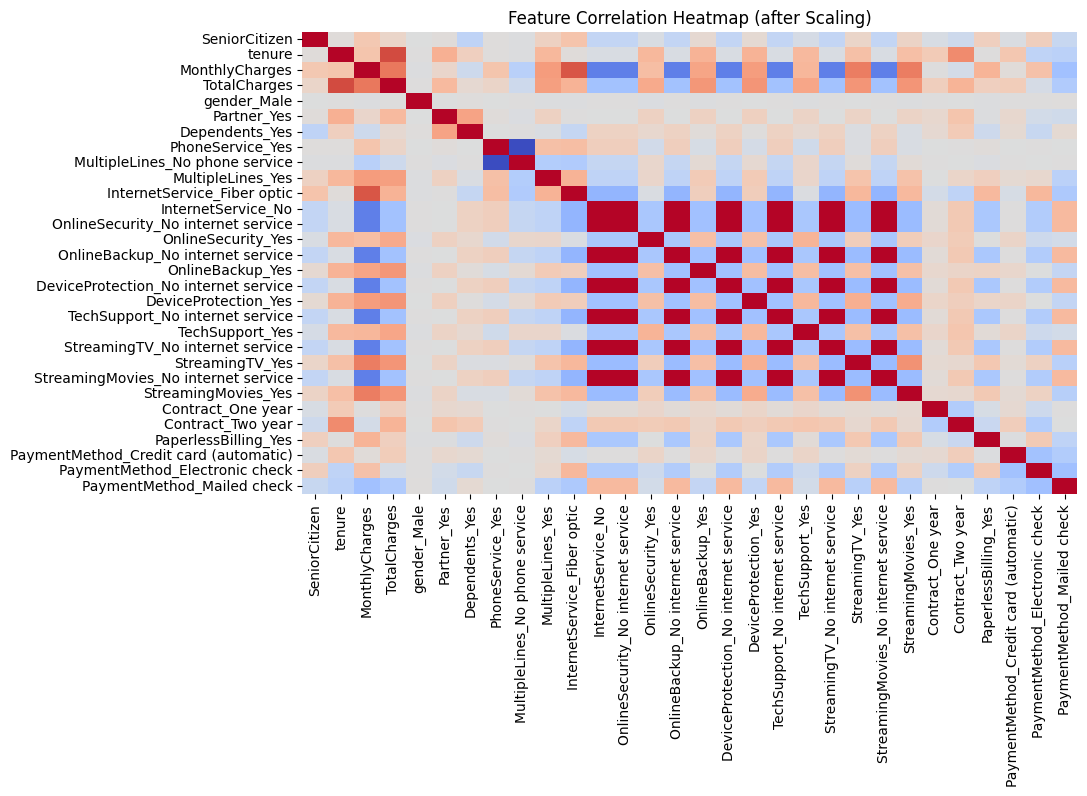

In [50]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.DataFrame(X_scaled, columns=df.drop(columns=['Churn_Yes']).columns).corr(), cmap="coolwarm", cbar=False)
plt.title("Feature Correlation Heatmap (after Scaling)")
plt.show()

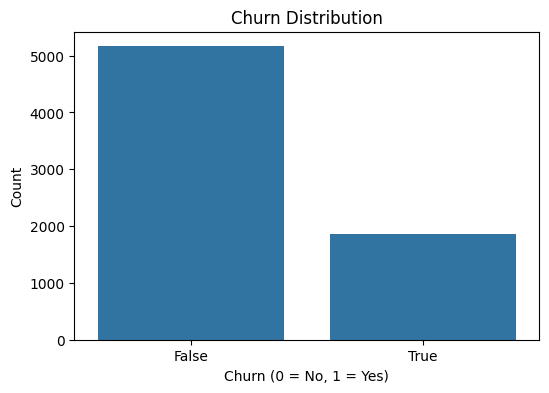

In [51]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

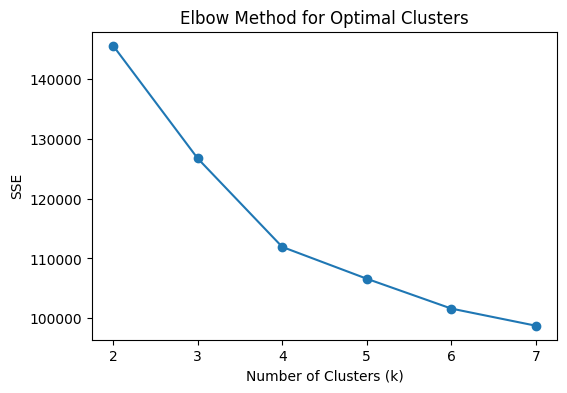

In [52]:
sse = []
for k in range(2,8):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    sse.append(km.inertia_)
plt.figure(figsize=(6,4))
plt.plot(range(2,8), sse, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE")
plt.show()

In [53]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans_pca = KMeans(n_clusters=2, random_state=42)
labels_pca = kmeans_pca.fit_predict(X_pca)

print("Silhouette Score (PCA):", silhouette_score(X_pca, labels_pca))
print("Davies–Bouldin Index (PCA):", davies_bouldin_score(X_pca, labels_pca))

Silhouette Score (PCA): 0.6843166563715728
Davies–Bouldin Index (PCA): 0.4183077026244762


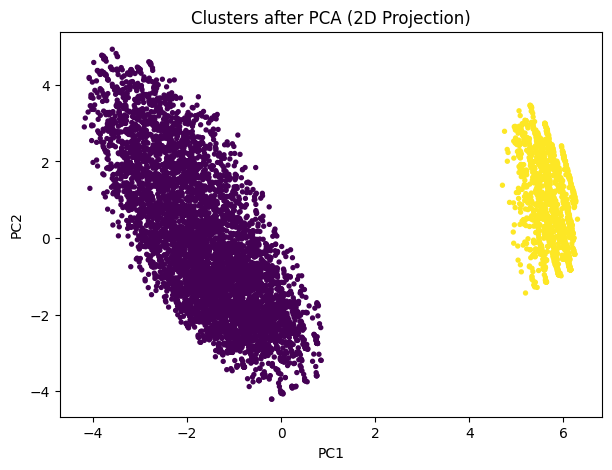

In [54]:
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_pca, cmap='viridis', s=8)
plt.title("Clusters after PCA (2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

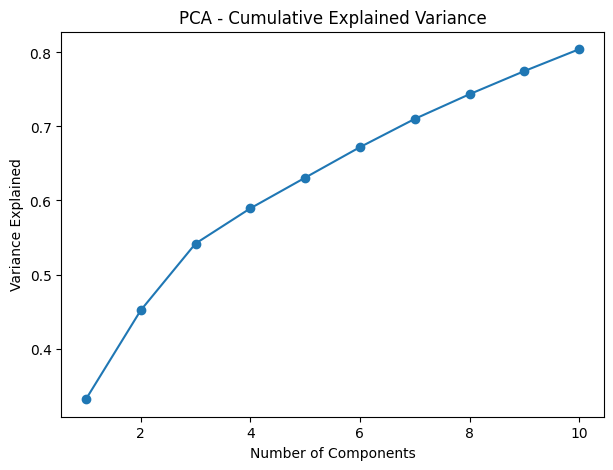

In [55]:
plt.figure(figsize=(7,5))
plt.plot(range(1,11), PCA(n_components=10).fit(X_scaled).explained_variance_ratio_.cumsum(), marker='o')
plt.title("PCA - Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.show()

In [56]:
input_dim = X_scaled.shape[1]
encoding_dim = 2

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=64, verbose=1)

encoder = models.Model(input_layer, encoded)
X_encoded = encoder.predict(X_scaled)

kmeans_enc = KMeans(n_clusters=2, random_state=42)
labels_enc = kmeans_enc.fit_predict(X_encoded)

print("Silhouette Score (Autoencoder):", silhouette_score(X_encoded, labels_enc))
print("Davies–Bouldin Index (Autoencoder):", davies_bouldin_score(X_encoded, labels_enc))

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1418
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8141
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7785
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7516
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7294
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7118
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7013
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6910
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6884
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6835
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6798
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6796
Epoch 13/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6791
Epoch 14/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6802
Epoch 15/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

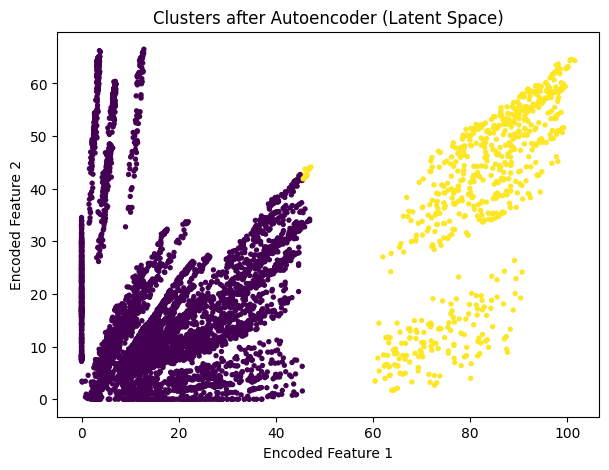

In [57]:
plt.figure(figsize=(7,5))
plt.scatter(X_encoded[:,0], X_encoded[:,1], c=labels_enc, cmap='viridis', s=8)
plt.title("Clusters after Autoencoder (Latent Space)")
plt.xlabel("Encoded Feature 1")
plt.ylabel("Encoded Feature 2")
plt.show()

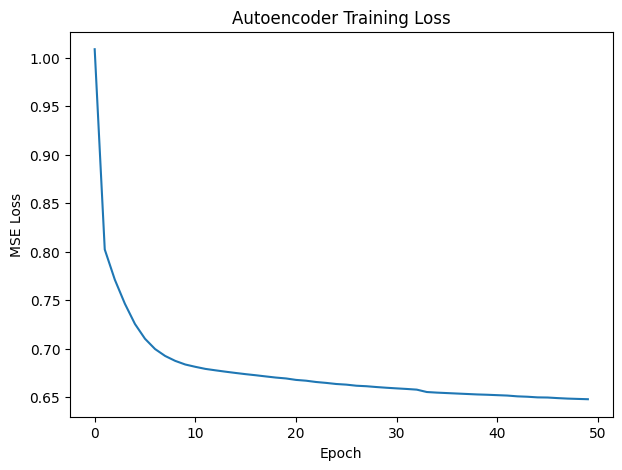

In [58]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'])
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

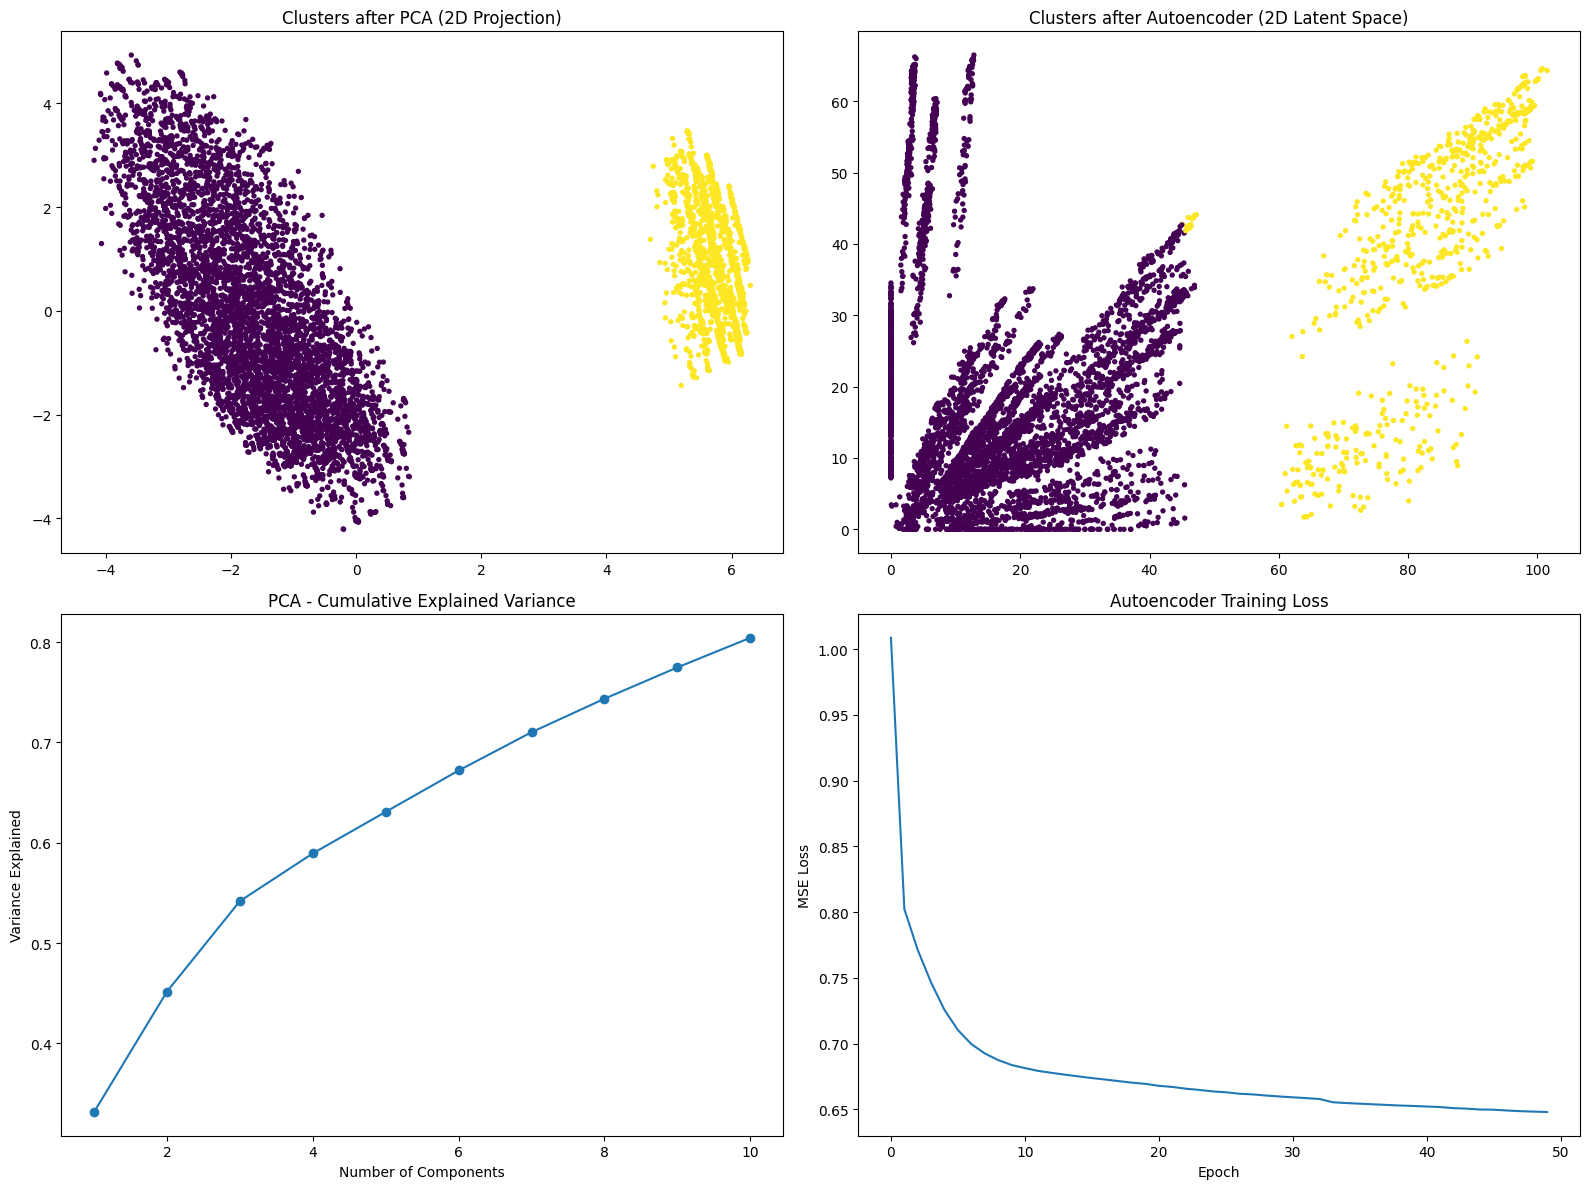

In [59]:
plt.figure(figsize=(16,12))

# 1. PCA projection
plt.subplot(2,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_pca, cmap='viridis', s=8)
plt.title('Clusters after PCA (2D Projection)')

# 2. Autoencoder latent space
plt.subplot(2,2,2)
plt.scatter(X_encoded[:,0], X_encoded[:,1], c=labels_enc, cmap='viridis', s=8)
plt.title('Clusters after Autoencoder (2D Latent Space)')

# 3. Explained variance by PCA
plt.subplot(2,2,3)
plt.plot(range(1,11), PCA(n_components=10).fit(X_scaled).explained_variance_ratio_.cumsum(), marker='o')
plt.title('PCA - Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')

# 4. Autoencoder training loss
plt.subplot(2,2,4)
plt.plot(history.history['loss'])
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

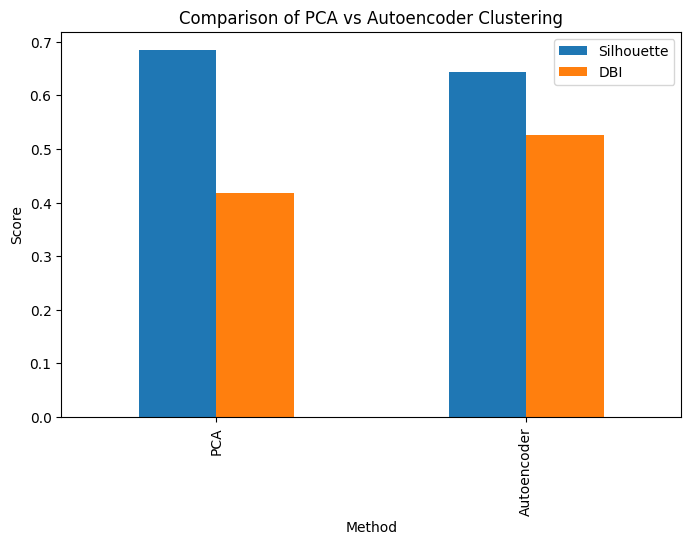

        Method  Silhouette       DBI
0          PCA    0.684317  0.418308
1  Autoencoder    0.644251  0.525923


In [60]:
scores = pd.DataFrame({
    "Method": ["PCA", "Autoencoder"],
    "Silhouette": [
        silhouette_score(X_pca, labels_pca),
        silhouette_score(X_encoded, labels_enc)
    ],
    "DBI": [
        davies_bouldin_score(X_pca, labels_pca),
        davies_bouldin_score(X_encoded, labels_enc)
    ]
})

plt.figure(figsize=(8,5))
scores.set_index("Method")[["Silhouette","DBI"]].plot(kind="bar", figsize=(8,5))
plt.title("Comparison of PCA vs Autoencoder Clustering")
plt.ylabel("Score")
plt.show()

print(scores)